1. Import Packages

In [59]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from nltk.tokenize import RegexpTokenizer  
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
import chart_studio.plotly as py
from plotly.graph_objs import *
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_fscore_support

2. Import data

In [2]:
os.chdir("/Users/andreasabia/Documents/ESCP/NLP")

In [3]:
data = pd.read_csv("./spam.csv",encoding='latin-1', usecols=["v1","v2"])

3. Explore data and clean

In [5]:
data = data.rename(columns={"v1":"label", "v2":"text"})

Convert labels to numerical variables

In [9]:
data['label_num'] = data.label.map({'ham':0, 'spam':1})
#from sklearn.preprocessing import LabelEncoder
#le = LabelEncoder()
#le.fit(data['label'])
#label = le.transform(data['label'])
#print(np.unique(label))
#print(np.unique(data['label_num']))

In [10]:
print(data.head())
print(data.shape)
print(data.label.value_counts())

  label                                               text  label_num
0   ham  Go until jurong point, crazy.. Available only ...          0
1   ham                      Ok lar... Joking wif u oni...          0
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...          1
3   ham  U dun say so early hor... U c already then say...          0
4   ham  Nah I don't think he goes to usf, he lives aro...          0
(5572, 3)
ham     4825
spam     747
Name: label, dtype: int64


### Modeling

In [11]:
X_train,X_test,y_train,y_test = train_test_split(data["text"],data["label_num"], test_size = 0.2, random_state = 42)

In [12]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(4457,)
(1115,)
(4457,)
(1115,)


4.1 Using Raw count features

In [13]:
vect = CountVectorizer()

In [14]:
vect.fit(X_train)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [15]:
print(vect.get_feature_names()[0:10])
print(vect.get_feature_names()[-10:])

['00', '000', '000pes', '008704050406', '0089', '0121', '01223585236', '0125698789', '02', '0207']
['ìï', 'û_', 'û_thanks', 'ûªm', 'ûªt', 'ûªve', 'ûï', 'ûïharry', 'ûò', 'ûówell']


In [16]:
print("Vocabulary size: {}".format(len(vect.vocabulary_)))
#print("Vocabulary content:\n {}".format(vect.vocabulary_))

Vocabulary size: 7735


In [17]:
X_train_df = vect.transform(X_train)
X_test_df = vect.transform(X_test)

4.1.1 MultinomialNB

In [18]:
prediction = dict()
model = MultinomialNB()
model.fit(X_train_df,y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [19]:
prediction["Multinomial"] = model.predict(X_test_df)

In [27]:
round(accuracy_score(y_test,prediction["Multinomial"]),4)

0.9839

In [28]:
print(classification_report(y_test,prediction["Multinomial"]))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       965
           1       0.99      0.89      0.94       150

    accuracy                           0.98      1115
   macro avg       0.98      0.95      0.96      1115
weighted avg       0.98      0.98      0.98      1115



In [29]:
conf_mat = confusion_matrix(y_test, prediction['Multinomial'])
print(conf_mat)

[[963   2]
 [ 16 134]]


In [30]:
conf_mat_normalized = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]
print(conf_mat_normalized)

[[0.99792746 0.00207254]
 [0.10666667 0.89333333]]


In [33]:
print("train score:", round(model.score(X_train_df, y_train),4))
print("test score:", round(model.score(X_test_df, y_test),4))

train score: 0.9944
test score: 0.9839


4.1.2 Logistic Regression

In [35]:
logmodel=LogisticRegression()
logmodel.fit(X_train_df,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [36]:
prediction["LR"] = logmodel.predict(X_test_df)

In [42]:
print(round(accuracy_score(y_test,prediction["LR"]),4))

print(classification_report(y_test,prediction["LR"]))

conf_mat = confusion_matrix(y_test, prediction['LR'])
print(conf_mat)
conf_mat_normalized = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]

print(conf_mat_normalized)

print("train score:", round(logmodel.score(X_train_df, y_train),4))
print("test score:", round(logmodel.score(X_test_df, y_test),4))

0.9785
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       965
           1       1.00      0.84      0.91       150

    accuracy                           0.98      1115
   macro avg       0.99      0.92      0.95      1115
weighted avg       0.98      0.98      0.98      1115

[[965   0]
 [ 24 126]]
[[1.   0.  ]
 [0.16 0.84]]
train score: 0.9984
test score: 0.9785


4.2 TF-IDF

In [43]:
A_train,A_test,b_train,b_test = train_test_split(data["text"],data["label_num"], test_size = 0.2, random_state = 42)

In [45]:
vectorizer = TfidfVectorizer(stop_words='english')
TFIDF_train_x = vectorizer.fit_transform(A_train)
tfidf_test_x = vectorizer.transform(A_test)

4.2.1 Logistic Regression

In [47]:
classifier = LogisticRegression()
classifier.fit(TFIDF_train_x, b_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [48]:
prediction["TFIDFLR"] = classifier.predict(tfidf_test_x)

In [55]:
print(round(accuracy_score(b_test,prediction["TFIDFLR"]),4))

print(classification_report(b_test,prediction["TFIDFLR"]))

conf_mat = confusion_matrix(b_test, prediction['TFIDFLR'])
print(conf_mat)
conf_mat_normalized = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]

print(conf_mat_normalized)

print("train score:", round(classifier.score(TFIDF_train_x, b_train),4))
print("test score:", round(classifier.score(tfidf_test_x, b_test),4))

0.9525
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       965
           1       0.97      0.67      0.79       150

    accuracy                           0.95      1115
   macro avg       0.96      0.83      0.88      1115
weighted avg       0.95      0.95      0.95      1115

[[962   3]
 [ 50 100]]
[[0.99689119 0.00310881]
 [0.33333333 0.66666667]]
train score: 0.9695
test score: 0.9525


4.2.2 MultinomialNB

In [53]:
model2 = MultinomialNB()
model2.fit(TFIDF_train_x,b_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [54]:
prediction["TFIDFNB"] = model2.predict(tfidf_test_x)

In [58]:
print(round(accuracy_score(b_test,prediction["TFIDFNB"]),4))

print(classification_report(b_test,prediction["TFIDFNB"]))

conf_mat = confusion_matrix(b_test, prediction['TFIDFNB'])
print(conf_mat)
conf_mat_normalized = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]

print(conf_mat_normalized)

print("train score:", round(model2.score(TFIDF_train_x, b_train),4))
print("test score:", round(model2.score(tfidf_test_x, b_test),4))

0.9668
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       965
           1       1.00      0.75      0.86       150

    accuracy                           0.97      1115
   macro avg       0.98      0.88      0.92      1115
weighted avg       0.97      0.97      0.96      1115

[[965   0]
 [ 37 113]]
[[1.         0.        ]
 [0.24666667 0.75333333]]
train score: 0.9838
test score: 0.9668


In [162]:
accuracy_score(y_test,prediction["TFIDFNB"])

0.9668161434977578

In [143]:
precision_recall_fscore_support(y_test,prediction["TFIDFNB"])[2].mean()

0.9202526091150369

### Visualization

In [60]:
py.sign_in('xxx', 'xxx')
trace1 = {
  "name": "Accuracy", 
  "type": "bar", 
  "x": ["V NB", "V LR", "TF NB", "TF LR"], 
  "y": [accuracy_score(y_test,prediction["Multinomial"]), accuracy_score(y_test,prediction["LR"]),\
        accuracy_score(y_test,prediction["TFIDFNB"]), accuracy_score(y_test,prediction["TFIDFLR"])]
}
trace2 = {
  "name": "Precision", 
  "type": "bar", 
  "x": ["V NB", "V LR", "TF NB", "TF LR"], 
  "y": [precision_recall_fscore_support(y_test,prediction["Multinomial"])[0][0],precision_recall_fscore_support(y_test,prediction["LR"])[0][0],\
        precision_recall_fscore_support(y_test,prediction["TFIDFNB"])[0][0],precision_recall_fscore_support(y_test,prediction["TFIDFLR"])[0][0]]
}
trace3 = {
  "name": "Recall", 
  "type": "bar", 
  "x": ["V NB", "V LR", "TF NB", "TF LR"], 
  "y": [precision_recall_fscore_support(y_test,prediction["Multinomial"])[1][1],precision_recall_fscore_support(y_test,prediction["LR"])[1][1],\
        precision_recall_fscore_support(y_test,prediction["TFIDFNB"])[1][1],precision_recall_fscore_support(y_test,prediction["TFIDFLR"])[1][1]]
}
trace4 = {
  "name": "F1 Score", 
  "type": "bar", 
  "x": ["V NB", "V LR", "TF NB", "TF LR"], 
  "y": [precision_recall_fscore_support(y_test,prediction["Multinomial"])[2].mean(),precision_recall_fscore_support(y_test,prediction["LR"])[2].mean(),\
        precision_recall_fscore_support(y_test,prediction["TFIDFNB"])[2].mean(),precision_recall_fscore_support(y_test,prediction["TFIDFLR"])[2].mean()]
}
data = Data([trace1, trace2, trace3, trace4])
layout = {"barmode": "group"}
fig = Figure(data=data, layout=layout)
plot_url = py.plot(fig)

In [61]:
vis=pd.DataFrame()

In [62]:
y= [precision_recall_fscore_support(y_test,prediction["Multinomial"])[0][0],precision_recall_fscore_support(y_test,prediction["LR"])[0][0],\
        precision_recall_fscore_support(y_test,prediction["TFIDFNB"])[0][0],precision_recall_fscore_support(y_test,prediction["TFIDFLR"])[0][0]]

In [63]:
b= [accuracy_score(y_test,prediction["Multinomial"]), accuracy_score(y_test,prediction["LR"]),\
        accuracy_score(y_test,prediction["TFIDFNB"]), accuracy_score(y_test,prediction["TFIDFLR"])]

In [64]:
a= [precision_recall_fscore_support(y_test,prediction["Multinomial"])[1][1],precision_recall_fscore_support(y_test,prediction["LR"])[1][1],\
        precision_recall_fscore_support(y_test,prediction["TFIDFNB"])[1][1],precision_recall_fscore_support(y_test,prediction["TFIDFLR"])[1][1]]

In [65]:
c= [precision_recall_fscore_support(y_test,prediction["Multinomial"])[2].mean(),precision_recall_fscore_support(y_test,prediction["LR"])[2].mean(),\
        precision_recall_fscore_support(y_test,prediction["TFIDFNB"])[2].mean(),precision_recall_fscore_support(y_test,prediction["TFIDFLR"])[2].mean()]

In [67]:
vis["Accuracy"]=b

In [68]:
vis["Recall"]=a

In [69]:
vis["Precision"]=y

In [70]:
vis["F1"]=c

In [71]:
vis["Model"]=["VNB","VLR","TFNB","TFLR"]

In [72]:
vis.set_index(vis.Model, inplace=True)

In [73]:
vis

,Accuracy,Recall,Precision,F1,Model
Model,,,,,
VNB,0.983857,0.893333,0.983657,0.963902,VNB
VLR,0.978475,0.840000,0.975733,0.950380,VLR
TFNB,0.966816,0.753333,0.963074,0.920253,TFNB
TFLR,0.952466,0.666667,0.950593,0.881853,TFLR


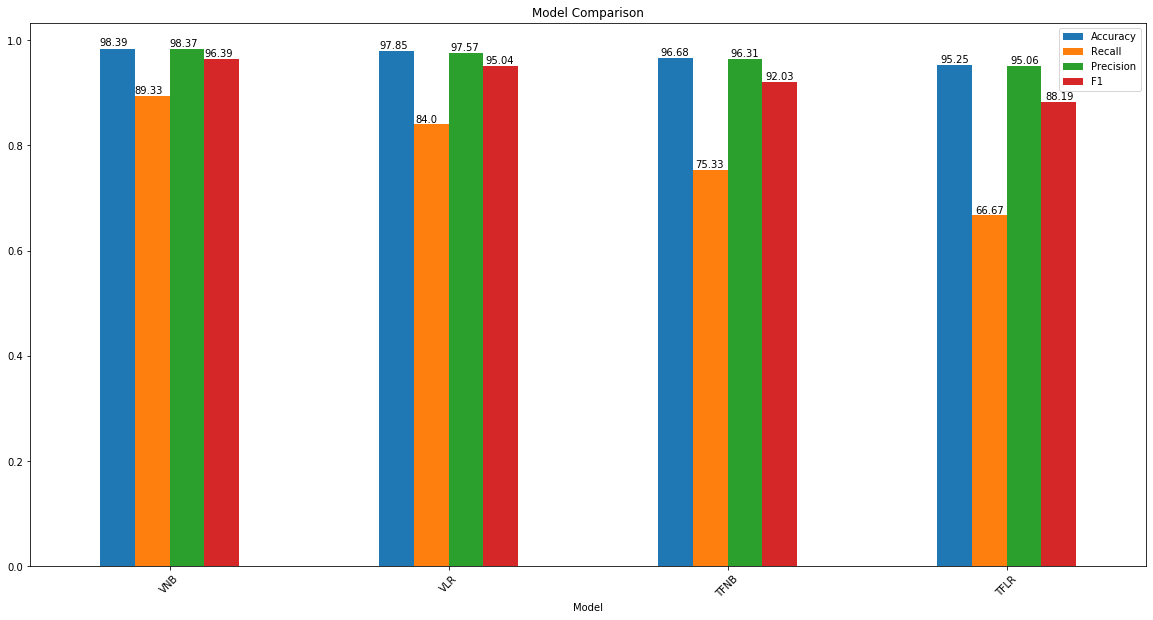

In [107]:
ax=vis.plot.bar(figsize=(20,10))
for p in ax.patches:
    ax.annotate(str((p.get_height()*100).round(2)), (p.get_x() * 1.005, p.get_height() * 1.005))

for tick in ax.get_xticklabels():
    tick.set_rotation(45)

plt.title("Model Comparison")
plt.show()

We can see from the above graph that Naive Bayes model with CountVectorizer is the most accurate model, with highest recall and precision!

### Features importance
I don't really know how to find the importance of the features. I found the codes below online, but intuitively they seem incorrect. I hope you could explain this better!

In [108]:
feature_array = np.array(vect.get_feature_names())
tfidf_sorting = np.argsort(TFIDF_train_x.toarray()).flatten()[::-1]

In [110]:
n = 50
top_n = feature_array[tfidf_sorting][:n]
top_n

array(['map', 'vs', 'gamestar', 'whore', 'dumb', 'dual', 'dub', 'dubsack',
       'duchess', 'ducking', 'dude', 'dudes', 'dudette', 'due', 'duffer',
       'dull', 'dungerees', 'dun', 'dsn', 'dunno', 'duo', 'durban',
       'durham', 'during', 'dusk', 'dust', 'dvd', 'dvg', 'dwn', 'dt',
       'dryer', 'dysentry', 'dry', 'dreams', 'dreamz', 'dress', 'dressed',
       'dresser', 'drink', 'drinkin', 'drinking', 'drinks', 'drivby',
       'drive', 'driver', 'drivin', 'driving', 'drms', 'drop', 'dropped'],
      dtype='<U34')

In [115]:
ham = model.feature_log_prob_[0, :].argsort()
spam = model.feature_log_prob_[1, :].argsort()

In [121]:
print(np.take(vect.get_feature_names(), ham[:40]))
print(np.take(vect.get_feature_names(), spam[:40]))

['00' 'randy' 'band' 'themob' 'lingerie' 'lines' 'linerental' 'd3wv'
 'global' 'eire' 'orno' 'cw25wx' 'bailiff' 'bahamas' 'dogs' 'gnarls'
 'rally' 'badass' 'thirtyeight' 'go2' 'backdoor' 'thnq' 'lily' 'gmw'
 'bangb' 'bangbabes' 'lionm' 'lnly' 'termsapply' 'getzed' 'llc'
 'lkpobox177hp51fl' 'ghost' 'liverpool' 'customersqueries' 'text82228'
 'textbuddy' 'textcomp' 'textoperator' 'textpod']
['jump' 'ned' 'necklace' 'neck' 'necessity' 'necessary' 'necessarily'
 'necesity' 'nearly' 'nearer' 'near' 'ne' 'ndship' 'nbme' 'nb' 'nav'
 'nauseous' 'naughty' 'natwest' 'nature' 'natural' 'nattil' 'needa'
 'nationwide' 'needed' 'needle' 'ni8' 'newspapers' 'newscaster' 'newquay'
 'newport' 'neway' 'nevr' 'nevering' 'neva' 'networking' 'nething'
 'netflix' 'neshanth' 'nervous']
